### CLIP: Contrastive Language-Image Pre-training 

https://towardsdatascience.com/simple-implementation-of-openai-clip-model-a-tutorial-ace6ff01d9f2


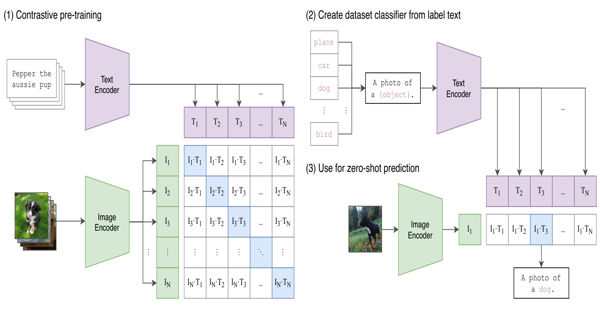

In [1]:
from io import BytesIO
import requests
from PIL import Image
r = requests.get('https://miro.medium.com/max/3662/1*tg7akErlMSyCLQxrMtQIYw.png')
Image.open(BytesIO(r.content)).resize((600,320))

    
    !pip install kaggle --upgrade

    # For Flickr 8k
    !kaggle datasets download -d adityajn105/flickr8k
    !unzip flickr8k.zip
    dataset = "8k"
    
    # For Flickr 30k
    !kaggle datasets download -d hsankesara/flickr-image-dataset
    !unzip flickr-image-dataset.zip
    dataset = "30k"
    
    !pip install timm
    !pip install transformers


In [2]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

/home/baiqiang/anaconda3/envs/pytorch181_cuda111_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [3]:
dataset = "8k"

In [4]:
## process dataset

if dataset == '8k':
    df = pd.read_csv('captions.txt')
    df['id'] = [id_ for id_ in range(df.shape[0]//5) for _ in range(5)]
    df.to_csv('captions.csv', index = False)
    df = pd.read_csv('captions.csv')
    image_path = './content/Images'
    captions_path = './content'
elif dataset == '30k':
    df = pd.read_csv("./content/flickr30k_images/results.csv", delimiter="|")
    df.columns = ['image', 'caption_number', 'caption']
    df['caption'] = df['caption'].str.lstrip()
    df['caption_number'] = df['caption_number'].str.lstrip()
    df.loc[19999, 'caption_number'] = '4'
    df.loc[19999, 'caption'] = 'A dog runs across the grass .'
    ids = [id_ for id_ in range(df.shape[0]//5) for _ in range(5)]
    df['id'] = ids
    df.to_csv('captions.csv', index=False)
    image_path = "./content/flickr30k_images/flickr30k_images"
    capthions_path = './content'
    
df.head()

,image,caption,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0


In [5]:
## configuration
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = 'distilbert-base-uncased'
    max_length = 200
    
    pretrained = True
    trainable = True
    temperature = 1.0
    
    # image size
    size = 224
    
    # projection head
    num_projections_layers = 1
    projection_dim = 256
    dropout = 0.1
    

In [6]:
## Utilities
class AvgMeter:
    def __init__(self, name = 'Metric'):
        self.name = name
        self.reset()
        
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, count = 1):               
        self.count += count
        self.sum +=  val*count
        self.avg = self.sum/self.count
        
    def __repr__(self):
        text = f"{self.name}:{self.avg:.4f}"
        return text
        
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

In [7]:
## prepare dataset loader 
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        there should be equal amount of image files and captions
        """        
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = \
                    tokenizer(list(captions), padding = True, truncation = True, max_length=CFG.max_length)
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()}
        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image = image)['image']
        item['image'] = torch.tensor(image).permute(2,0,1).float() # channel first
        item['caption'] = self.captions[idx]
        return item
        
    def __len__(self):
        return len(self.captions)
        
## get transforms
def get_transforms(mode = 'train'):
    if mode == 'train':
        return A.Compose(
            [
             A.Resize(CFG.size, CFG.size, always_apply = True),
             A.Normalize(max_pixel_value=255.0, always_apply=True)
            ]
        )
    else:
        return A.Compose(
            [
             A.Resize(CFG.size, CFG.size, always_apply=True),
             A.Normalize(max_pixel_value=255.0, always_apply=True)
            ]
        )


In [8]:
## Image Encoder
class ImageEncoder(nn.Module):
    """
    Encode image to a fixed size vector
    """
    def __init__(self, model_name = CFG.model_name, pretrained = CFG.pretrained, trainable = CFG.trainable):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained, num_classes = 0, global_pool = 'avg')
        for p in self.model.parameters():
            p.requires_grad = trainable
            
    def forward(self, x):
        return self.model(x)

In [9]:
## Text Encoder
class TextEncoder(nn.Module):
    """
    encode text into a fixed size vector
    """
    def __init__(self, model_name=CFG.text_encoder_model, pretrained = CFG.pretrained, trainable = CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable
        
        # use the hidden representation of CLS token as sentence's embedding
        self.target_token_idx = 0
        
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:,self.target_token_idx,:]

In [10]:
## Projection Head
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim = CFG.projection_dim, dropout = CFG.dropout):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim) # keep dim
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected # residual
        x = self.layer_norm(x) # layer norm
        return x

In [11]:
## Clip
class CLIPModel(nn.Module):
    def __init__(self, 
                 temperature = CFG.temperature, 
                 image_embedding = CFG.image_embedding,
                 text_embedding = CFG.text_embedding):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature
        
    def forward(self, x):    
        # compute features
        image_features = self.image_encoder(x['image'])
        text_features = self.text_encoder(input_ids = x['input_ids'], attention_mask=x['attention_mask'])
        # compute projections
        image_projections = self.image_projection(image_features)
        text_projections = self.text_projection(text_features)
        # calculate softmax
        logits = (text_projections @ image_projections.T) / self.temperature
        images_similarities = image_projections @ image_projections.T
        texts_similarities = text_projections @ text_projections.T
        targets = F.softmax(
            (images_similarities+texts_similarities)/2 * self.temperature, dim=-1)
        # calculate CE loss
        texts_loss = cross_entropy(logits, targets, reduction = 'None')
        images_loss = cross_entropy(logits.T, targets.T, reduction = 'None')
        loss = (images_loss + texts_loss) /2.0 # 
        return loss.mean()
    
def cross_entropy(preds, targets, reduction = 'None'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == 'None':
        return loss
    elif reduction == 'mean':
        return loss.mean()
        

In [12]:
## loss example
batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In [13]:
## Dataloaders
def make_train_val_dfs():
    df = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = df['id'].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(image_ids, size = int(0.2 * len(image_ids)), replace = False)
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_df  = df[df['id'].isin(train_ids)].reset_index(drop=True)
    valid_df  = df[df['id'].isin(valid_ids)].reset_index(drop=True)
    return train_df, valid_df

def build_loaders(df, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
                df['image'].values,
                df['caption'].values,
                tokenizer = tokenizer,
                transforms= transforms)
    
    dataloader = torch.utils.data.DataLoader(
                dataset,
                batch_size = CFG.batch_size,
                num_workers = CFG.num_workers,
                shuffle = True if mode == 'train' else False
    )
    
    return dataloader
    


In [14]:
## Train
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != 'caption'}
        loss = model(batch)
        optimizer.zero_grad() # clear grad
        loss.backward()
        optimizer.step()
        
        if step == 'batch':
            lr_schedulear.step()
        
        count = batch["image"].size(0)

        loss_meter.update(loss.item(), count)
        
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr = get_lr(optimizer))
        
        return loss_meter
    
    
## Validation
def valid_epoch(model, valid_loader):
   
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader, total = len(valid_loader))
    
    for batch in tqdm_object:
        batch = {k:v.to(CFG.device) for k, v in batch.items() if k != 'caption'}
        loss = model(batch)
        
        count = batch['image'].size(0)
        loss_meter.update(loss.item(), count)
        
        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
        
    return loss_meter
       

In [15]:
## Training
def main():
    
    # init dataset loaders
    train_df, valid_df = make_train_val_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode = 'train')
    valid_loader = build_loaders(valid_df, tokenizer, mode = 'valid')
    
    # init model
    model = CLIPModel().to(CFG.device)
    
    # init optimizer
    params = [
        {"params": model.image_encoder.parameters(), 'lr': CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), 'lr': CFG.text_encoder_lr},
        {"params": itertools.chain(model.image_projection.parameters(), model.text_projection.parameters()),
                     'lr': CFG.head_lr, "weight_decay": CFG.weight_decay}]
    
    optimizer = torch.optim.AdamW(params, weight_decay=0.0)
    
    # lr schedule
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                              mode='min', 
                                                              patience=CFG.patience, 
                                                              factor=CFG.factor)
    step = 'epoch'
    
    # train
    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        
        print(f"Epoch:{epoch + 1}")
        
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
            
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print('Best Model Saved!')
                  
        lr_scheduler.step(valid_loss.avg)
        

In [ ]:
main()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:1


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Best Model Saved!
Epoch:2


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Best Model Saved!
Epoch:3


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Best Model Saved!
Epoch:4


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]